# Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras

From https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


## Problem Description
Given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn

In [52]:
# read dataset, First column is Month in "yyyy-mm" and second column is passengers .
airline_pax = pd.read_csv("data/brownlee/airline-passengers.csv", parse_dates=["Month"], dtype={"Passengers": np.int32}, engine="python")
print(airline_pax.head())

       Month  Passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121


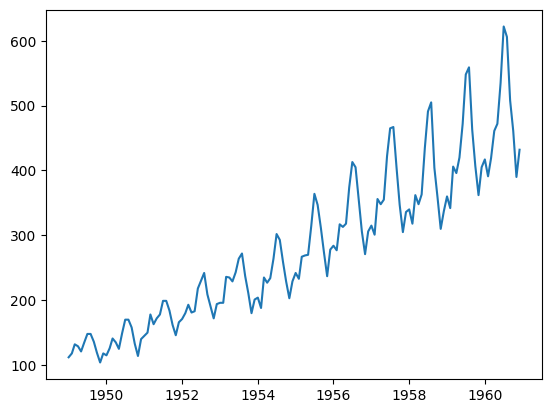

In [53]:
plt.figure()
plt.plot(airline_pax["Month"], airline_pax["Passengers"])
plt.show()

## Long Short-Term Memory (LSTM) Network

LSTM network is a recurrent neural network (RNN) trained using Backpropagation Through Time that overcomes the vanishing gradient problem.

* Instead of neurons, LSTM networks have memory blocks connected through layers.
* A block contains gates that manage the block’s **state** and **output**.
* A block operates upon an input sequence, and each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional.

3 types of gate:

* **Forget Gate**: conditionally decides what information to throw away from the block
* **Input Gate**: conditionally decides which values from the input to update the memory state
* **Output Gate**: conditionally decides what to output based on input and the memory of the block

In [54]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [55]:
print(airline_pax.shape)  # (144, 2) = 144 rows with 2 columns
print(airline_pax.head())
dataset_int = airline_pax[["Passengers"]].copy().values  # int np.ndarray
print(type(dataset_int), dataset_int.dtype, dataset_int.shape)  # Shape is (144, 1) 144 rows, 1 column
dataset = dataset_int.astype("float32")  # ndarray,not-normalised
print(type(dataset), dataset.dtype, dataset.shape)

(144, 2)
       Month  Passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121
<class 'numpy.ndarray'> int32 (144, 1)
<class 'numpy.ndarray'> float32 (144, 1)


LSTMs are sensitive to the scale of input data, due to the sigmoid or tanh activation functions.  Rescale to 0-1.

In [56]:
# Normalise the dataset
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
data_seq = scaler.fit_transform(dataset)  # normalised
print(data_seq.shape)

(144, 1)


In [57]:
# Split into training and test subsets
train_size = int(len(data_seq) * 0.67)
test_size = len(data_seq) - train_size

train_seq, test_seq = data_seq[0:train_size, :], data_seq[train_size:len(data_seq), :]
print(len(train_seq), len(test_seq))

96 48


Define actual data sets (sequence, label) from the sequences.

In [58]:
def create_dataset(sequence: pd.DataFrame, look_back: int = 1) -> tuple[np.ndarray, np.ndarray]:
    """Convert SEQUENCE of values into a dataset matrix with a given LOOK_BACK"""
    dataX: list(np.ndarray) = []
    dataY: list(float) = []
    for i in range(len(sequence)-look_back-1):  # 144 - 1 + 1 = 0..143 inclusive.
        a = sequence[i:(i+look_back), 0]  # look_back rows starting from i, column 0
        dataX.append(a)  # appends an ndarray of length look_back
        dataY.append(sequence[i + look_back, 0])  # appends a float value.
    return np.array(dataX), np.array(dataY)

In [59]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_seq, look_back)
testX, testY = create_dataset(test_seq, look_back)

### Reshape data from `[samples, features]` to LSTM requirement of `[samples, time_steps, features]`.

In [60]:
# reshape input to be [samples, time steps, features] with time steps == 1
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(94, 1, 1) (46, 1, 1) (94,) (46,)


## Model Definition

* One visible layer with 1 input
* Hidden layer with 4 LSTM blocks or neurons, with default sigmoid activation.
* Output layer that makes a single value prediction.

In [61]:
# Create the network
model = tf.keras.models.Sequential()  # Linear stack of layers
model.add(tf.keras.layers.Input(shape=(1, look_back)))  # inputs are batches of rank-2 tensor (matrices), with 1 value per dimension.
model.add(tf.keras.layers.LSTM(4))  # 4 units, ie. output space of dimensionality 4
model.add(tf.keras.layers.Dense(1))  # Dimensionality of the output space, ie. 1 output value.
model.compile(loss='mean_squared_error', optimizer='adam')

Train the model for 100 epochs, with a batch size of 1.

In [62]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - 22ms/step - loss: 0.0360
Epoch 2/100
94/94 - 0s - 2ms/step - loss: 0.0165
Epoch 3/100
94/94 - 0s - 2ms/step - loss: 0.0123
Epoch 4/100
94/94 - 0s - 2ms/step - loss: 0.0110
Epoch 5/100
94/94 - 0s - 2ms/step - loss: 0.0100
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0090
Epoch 7/100
94/94 - 0s - 3ms/step - loss: 0.0080
Epoch 8/100
94/94 - 0s - 3ms/step - loss: 0.0071
Epoch 9/100
94/94 - 0s - 3ms/step - loss: 0.0062
Epoch 10/100
94/94 - 0s - 3ms/step - loss: 0.0054
Epoch 11/100
94/94 - 0s - 2ms/step - loss: 0.0046
Epoch 12/100
94/94 - 0s - 2ms/step - loss: 0.0040
Epoch 13/100
94/94 - 0s - 3ms/step - loss: 0.0035
Epoch 14/100
94/94 - 0s - 2ms/step - loss: 0.0031
Epoch 15/100
94/94 - 0s - 3ms/step - loss: 0.0027
Epoch 16/100
94/94 - 0s - 3ms/step - loss: 0.0025
Epoch 17/100
94/94 - 0s - 3ms/step - loss: 0.0023
Epoch 18/100
94/94 - 0s - 3ms/step - loss: 0.0022
Epoch 19/100
94/94 - 0s - 2ms/step - loss: 0.0021
Epoch 20/100
94/94 - 0s - 2ms/step - loss: 0.0021
Epoch 21

## Make Predictions

Once the model is fit, you can estimate the performance of the model on the train and test datasets. This will give you a point of comparison for new models.

Note that you will invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [63]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(sklearn.metrics.mean_squared_error(trainY[0], trainPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(sklearn.metrics.mean_squared_error(testY[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train Score: 22.74 RMSE
Test Score: 50.55 RMSE


Generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, you must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

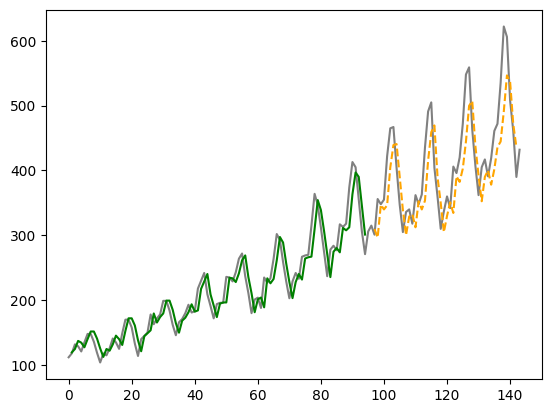

In [68]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_seq)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_seq)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_seq), linestyle="solid", color="grey")
plt.plot(trainPredictPlot, linestyle="solid", color="green")
plt.plot(testPredictPlot, linestyle="dashed", color="orange")
plt.show()